In [2]:
!pip uninstall opencv-python -y
# downgrade OpenCV a bit since some none-free features are not avilable
!pip install opencv-contrib-python==3.4.2.17 --force-reinstall

Uninstalling opencv-python-4.1.2.30:
  Successfully uninstalled opencv-python-4.1.2.30
     |████████████████████████████████| 30.6MB 136kB/s 
     |████████████████████████████████| 20.2MB 1.2MB/s 
ERROR: imgaug 0.2.9 requires opencv-python, which is not installed.
ERROR: dopamine-rl 1.0.5 requires opencv-python>=3.4.1.15, which is not installed.
ERROR: albumentations 0.1.12 requires opencv-python, which is not installed.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.18.4
    Uninstalling numpy-1.18.4:
      Successfully uninstalled numpy-1.18.4
  Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


In [0]:
# import basic functions
import numpy as np 
import cv2
import glob
import os 
import matplotlib.pyplot as plt

from google.colab.patches import cv2_imshow

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!ls 'drive/My Drive/CVIT Day 4/Panorama/Eg1'

img2_1.png  img2_2.png	img2_3.png


In [0]:
image1=cv2.imread('drive/My Drive/CVIT Day 4/Feature Matching/box.png',cv2.IMREAD_GRAYSCALE)
image2=cv2.imread('drive/My Drive/CVIT Day 4/Feature Matching/box_in_scene.png',cv2.IMREAD_GRAYSCALE)

In [0]:
# Initiate Sift detector
sift =cv2.xfeatures2d.SIFT_create()
kp1, des1 = sift.detectAndCompute(image1,None)
kp2, des2 = sift.detectAndCompute(image2,None)

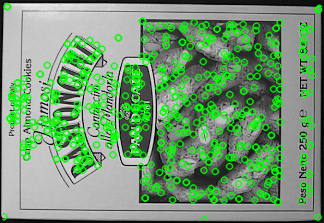

In [0]:
cv2_imshow(cv2.drawKeypoints(image1,kp1,None,color=(0,255,0)))

In [0]:
pixel_loc = (15, 15)
i,j = pixel_loc

window = image1[i-1:i+2, j-1:j+2]
intensities = window.ravel()

intensities
# plt.imshow(window, cmap="gray")

array([196, 195, 198, 196, 196, 199, 197, 196, 198], dtype=uint8)

Text(0.5, 0, '(b)')

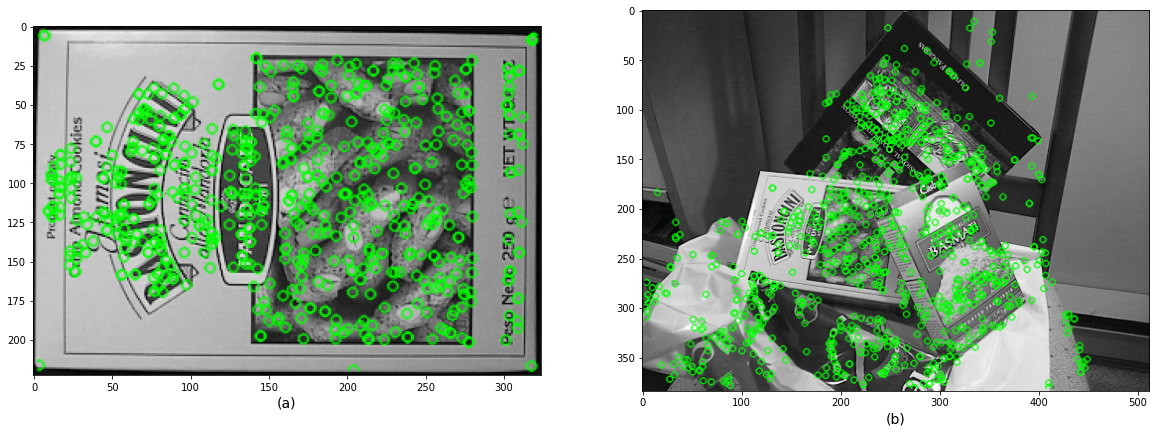

In [0]:
# display the keypoints and features detected on both images
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,8), constrained_layout=False)
ax1.imshow(cv2.drawKeypoints(image1,kp1,None,color=(0,255,0)))
ax1.set_xlabel("(a)", fontsize=14)
ax2.imshow(cv2.drawKeypoints(image2,kp2,None,color=(0,255,0)))
ax2.set_xlabel("(b)", fontsize=14)

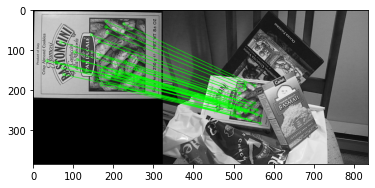

In [0]:
match = cv2.BFMatcher()
matches = match.knnMatch(des1,des2,k=2)

good = []
for m,n in matches:
    if m.distance < 0.5*n.distance:
        good.append(m)

draw_params = dict(matchColor=(0,255,0),
                       singlePointColor=None,
                       flags=2)

img3 = cv2.drawMatches(image1,kp1,image2,kp2,good,None,**draw_params)
plt.imshow(img3)

## panorama

In [0]:
image1=cv2.imread('drive/My Drive/CVIT Day 4/Panorama/Eg1/img2_2.png')
image2=cv2.imread('drive/My Drive/CVIT Day 4/Panorama/Eg1/img2_1.png')

image1_gray=cv2.cvtColor(image1,cv2.COLOR_BGR2GRAY)
image2_gray=cv2.cvtColor(image2,cv2.COLOR_BGR2GRAY)

image1=cv2.cvtColor(image1,cv2.COLOR_BGR2RGB)
image2=cv2.cvtColor(image2,cv2.COLOR_BGR2RGB)

In [0]:
# Initiate Sift detector
sift =cv2.xfeatures2d.SIFT_create()
kp1, des1 = sift.detectAndCompute(image1_gray,None)
kp2, des2 = sift.detectAndCompute(image2_gray,None)

Text(0.5, 0, '(b)')

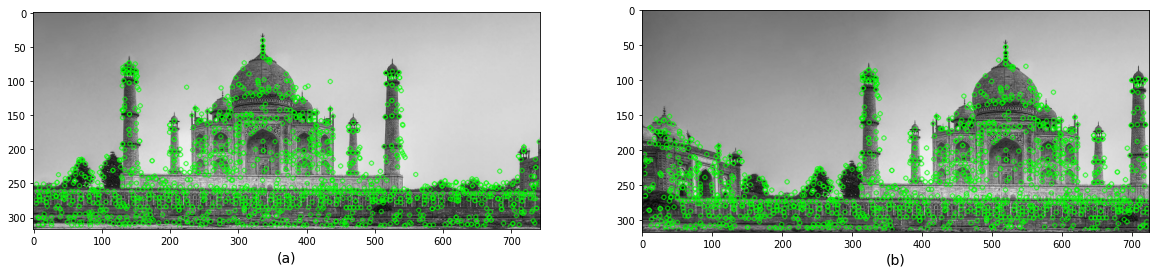

In [0]:
# display the keypoints and features detected on both images
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,8), constrained_layout=False)
ax1.imshow(cv2.drawKeypoints(image1_gray,kp1,None,color=(0,255,0)))
ax1.set_xlabel("(a)", fontsize=14)
ax2.imshow(cv2.drawKeypoints(image2_gray,kp2,None,color=(0,255,0)))
ax2.set_xlabel("(b)", fontsize=14)

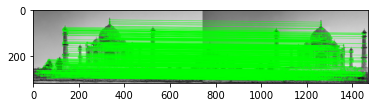

In [0]:
match = cv2.BFMatcher()
matches = match.knnMatch(des1,des2,k=2)

good = []
for m,n in matches:
    if m.distance < 0.03*n.distance:
        good.append(m)

draw_params = dict(matchColor=(0,255,0),
                       singlePointColor=None,
                       flags=2)

img3 = cv2.drawMatches(image1_gray,kp1,image2_gray,kp2,good,None,**draw_params)
plt.imshow(img3)

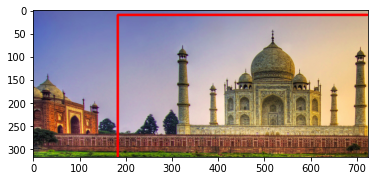

In [0]:
MIN_MATCH_COUNT = 10
if len(good) > MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

    h,w = image2_gray.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts, M)
    img2 = cv2.polylines(image2,[np.int32(dst)],True,255,3, cv2.LINE_AA)

    plt.imshow(img2)
else:
    print("Not enought matches are found - %d/%d", (len(good)/MIN_MATCH_COUNT))

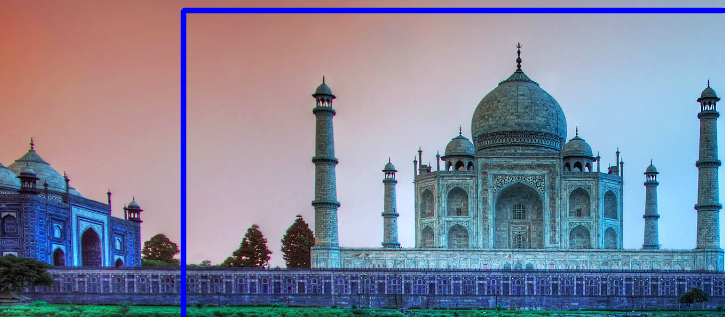

In [0]:
dst = cv2.warpPerspective(image1, M, (image1.shape+image2.shape)[:2][::-1])
dst[:image2.shape[0],:image2.shape[1]] = image2

cv2_imshow(image2)

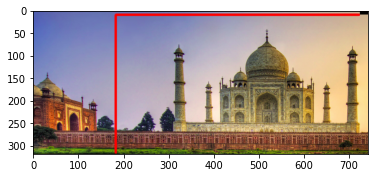

In [0]:
def trim(frame):
    #crop top
    if not np.sum(frame[0]):
        return trim(frame[1:])
    #crop bottom
    if not np.sum(frame[-1]):
        return trim(frame[:-2])
    #crop left
    if not np.sum(frame[:,0]):
        return trim(frame[:,1:])
    #crop right
    if not np.sum(frame[:,-1]):
        return trim(frame[:,:-2])
    return frame

plt.imshow(trim(dst))
#cv2.imsave("original_image_stitched_crop.jpg", trim(dst))

In [0]:
def trim(frame):
          #crop top
          if not np.sum(frame[0]):
              return trim(frame[1:])
          #crop bottom
          if not np.sum(frame[-1]):
              return trim(frame[:-2])
          #crop left
          if not np.sum(frame[:,0]):
              return trim(frame[:,1:])
          #crop right
          if not np.sum(frame[:,-1]):
              return trim(frame[:,:-2])
          return frame

def panorama(path_right,path_left):

      image1=cv2.imread(path_right)
      image2=cv2.imread(path_left)

      image1_gray=cv2.cvtColor(image1,cv2.COLOR_BGR2GRAY)
      image2_gray=cv2.cvtColor(image2,cv2.COLOR_BGR2GRAY)

      image1=cv2.cvtColor(image1,cv2.COLOR_BGR2RGB)
      image2=cv2.cvtColor(image2,cv2.COLOR_BGR2RGB)

      # Initiate Sift detector
      sift =cv2.xfeatures2d.SIFT_create()
      kp1, des1 = sift.detectAndCompute(image1_gray,None)
      kp2, des2 = sift.detectAndCompute(image2_gray,None)

      # display the keypoints and features detected on both images
      #fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,8), constrained_layout=False)
      #ax1.imshow(cv2.drawKeypoints(image1_gray,kp1,None,color=(0,255,0)))
      #ax1.set_xlabel("(a)", fontsize=14)
      #ax2.imshow(cv2.drawKeypoints(image2_gray,kp2,None,color=(0,255,0)))
      #ax2.set_xlabel("(b)", fontsize=14)

      match = cv2.BFMatcher()
      matches = match.knnMatch(des1,des2,k=2)

      good = []
      for m,n in matches:
          if m.distance < 0.03*n.distance:
              good.append(m)

      draw_params = dict(matchColor=(0,255,0),
                            singlePointColor=None,
                            flags=2)

      img3 = cv2.drawMatches(image1_gray,kp1,image2_gray,kp2,good,None,**draw_params)
      #plt.imshow(img3)

      MIN_MATCH_COUNT = 10
      if len(good) > MIN_MATCH_COUNT:
          src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
          dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

          M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

          h,w = image2_gray.shape
          pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
          dst = cv2.perspectiveTransform(pts, M)
          #img2 = cv2.polylines(image2,[np.int32(dst)],True,255,3, cv2.LINE_AA)

          #plt.imshow(img2)
      else:
          print("Not enought matches are found - %d/%d", (len(good)/MIN_MATCH_COUNT))

      dst = cv2.warpPerspective(image1,M,(image2.shape[1] + image1.shape[1], image2.shape[0]+ image1.shape[0]))
      dst[0:image2.shape[0],0:image2.shape[1]] = image2
      #plt.imshow(dst)

      
      #plt.imshow(trim(dst))
      #cv2.imsave("original_image_stitched_crop.jpg", trim(dst))
      return(trim(dst))

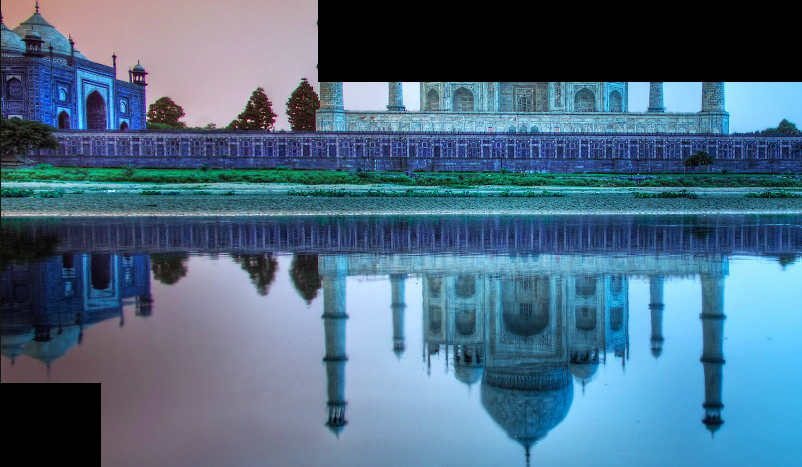

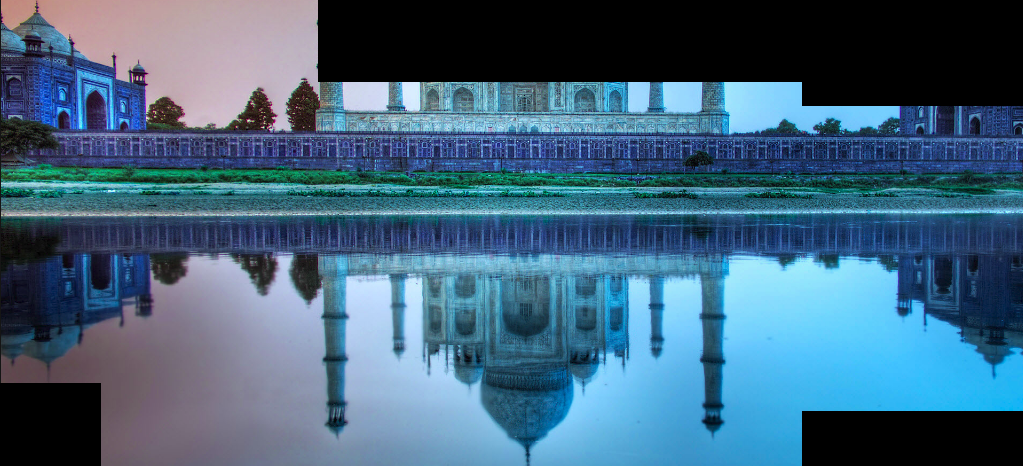

In [0]:
root='drive/My Drive/CVIT Day 4/Panorama/Eg2/'
images=os.listdir(root)
save_path='drive/My Drive/CVIT Day 4/Panorama/Outputs/Eg2/'

for i in range (len(images)-1):
    path_right=root+images[i+1] 

    if i==0:
        path_left=root+images[i]
    else:
        path_left=save_image

    img_new=panorama(path_right,path_left)
    save_image=save_path+images[i+1][:-4]+"output.png"

    cv2.imwrite(save_image, cv2.cvtColor(img_new, cv2.COLOR_RGB2BGR))
    cv2_imshow(img_new)

In [7]:
# own home images

cv2_imshow(panorama("img0.jpg", "img1.jpg"))

Not enought matches are found - %d/%d 0.0


UnboundLocalError: ignored